In [1]:
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.metrics import roc_curve, accuracy_score
from scipy import stats
from sklearn.model_selection import StratifiedKFold
import warnings
import pandas as pd
pd.options.display.max_columns = None
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import warnings
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier as kNearestNeighbors
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.ensemble import EasyEnsemble
from imblearn.ensemble import BalanceCascade
warnings.filterwarnings('ignore')
%matplotlib inline

### 1、读取数据

In [2]:
train = pd.read_csv('EdTech_train_data.csv')
X = train.drop(['No','rank'],axis=1)
y = train['rank']

### 2、转化为二分类问题

In [3]:
y[y!=0]=123
print(y.value_counts())

123    740
0      160
Name: rank, dtype: int64


### 3、随便使用一个分类器试试

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
conf_mats=[]
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    labels = list(set(y_test))
    conf_mat = confusion_matrix(y_test, y_pred, labels = labels)
    print('conf_mat:\n', conf_mat)
    conf_mats.append(conf_mat)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

conf_mat:
 [[11  5]
 [ 3 71]]
accuracy: 0.9111111111111111
conf_mat:
 [[ 7  9]
 [ 2 72]]
accuracy: 0.8777777777777778
conf_mat:
 [[12  4]
 [ 8 66]]
accuracy: 0.8666666666666667
conf_mat:
 [[11  5]
 [ 8 66]]
accuracy: 0.8555555555555555
conf_mat:
 [[ 9  7]
 [ 1 73]]
accuracy: 0.9111111111111111
conf_mat:
 [[10  6]
 [ 2 72]]
accuracy: 0.9111111111111111
conf_mat:
 [[ 8  8]
 [ 3 71]]
accuracy: 0.8777777777777778
conf_mat:
 [[ 8  8]
 [ 3 71]]
accuracy: 0.8777777777777778
conf_mat:
 [[10  6]
 [ 3 71]]
accuracy: 0.9
conf_mat:
 [[11  5]
 [ 1 73]]
accuracy: 0.9333333333333333
mean_acc 0.8922222222222222


### 4、尝试了采样和ensemble方法来处理不均衡数据，但是效果不好，数据的不均衡情况并不严重，放弃该想法

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
conf_mats=[]

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    ee = EasyEnsemble(n_subsets=5)
    X_resampled, y_resampled = ee.fit_sample(X, y)
    y_preds = np.zeros((len(X_test),5))
    for i in range(5):
        model = RandomForestClassifier(n_estimators=100,random_state=2, max_depth=20)
        model.fit(X_resampled[i],y_resampled[i])
        y_preds[:,i] = model.predict(X_test)
    result1 = []
    for y_pred in y_preds:
        cou_123 = 0
        cou_0 = 0
        for i in range(5):
            if y_pred[i]!=0:
                cou_123+=1
            else:
                cou_0+=1
        if cou_123 > cou_0:
            result1.append(123)
        else:
            result1.append(0)   
    model = RandomForestClassifier(n_estimators=100,random_state=2, max_depth=20)
    model.fit(X_train, y_train)
    result2 = model.predict(X_test)
    result = []
    for i in range(len(result1)):
        result.append(123)
    for i in range(len(result1)):
        if result1[i] == 0:
            result[i] = 0
    
    for i in range(len(result2)):
        if result2[i] == 123 and result[i]!=0:
            result[i] = 123
#     print(result)
#     print(y_test)    
    
    labels = list(set(y_test))
    conf_mat = confusion_matrix(y_test, result, labels = labels)
    print('conf_mat:\n', conf_mat)
    conf_mats.append(conf_mat)
    acc = accuracy_score(y_test,result)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

conf_mat:
 [[16  0]
 [11 63]]
accuracy: 0.8777777777777778
conf_mat:
 [[16  0]
 [11 63]]
accuracy: 0.8777777777777778
conf_mat:
 [[16  0]
 [17 57]]
accuracy: 0.8111111111111111
conf_mat:
 [[16  0]
 [14 60]]
accuracy: 0.8444444444444444
conf_mat:
 [[16  0]
 [16 58]]
accuracy: 0.8222222222222222
conf_mat:
 [[16  0]
 [16 58]]
accuracy: 0.8222222222222222
conf_mat:
 [[16  0]
 [16 58]]
accuracy: 0.8222222222222222
conf_mat:
 [[16  0]
 [11 63]]
accuracy: 0.8777777777777778
conf_mat:
 [[16  0]
 [25 49]]
accuracy: 0.7222222222222222
conf_mat:
 [[16  0]
 [12 62]]
accuracy: 0.8666666666666667
mean_acc 0.8344444444444443


### 5、特征工程

#### 5.1分析总体特征相关性

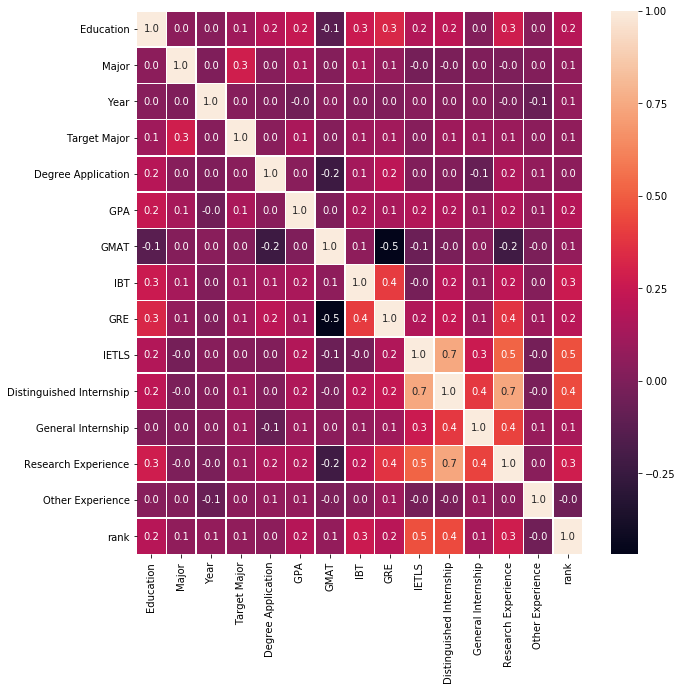

In [6]:
f,ax = plt.subplots(figsize=(10, 10))
df_cor = X
df_cor['rank'] = y.values
sns.heatmap(df_cor.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

#### 5.2处理类别型特征

策略1：不做任何特征工程

In [7]:
train = pd.read_csv('EdTech_train_data.csv')
X = train.drop(['No','rank'],axis=1).values
y = train['rank'].values
y[y!=0]=123

1)用RF

In [8]:
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9111111111111111
accuracy: 0.8777777777777778
accuracy: 0.8666666666666667
accuracy: 0.8555555555555555
accuracy: 0.9111111111111111
accuracy: 0.9111111111111111
accuracy: 0.8777777777777778
accuracy: 0.8777777777777778
accuracy: 0.9
accuracy: 0.9333333333333333
mean_acc 0.8922222222222222


2）用XGB

In [9]:
model = XGBClassifier(n_estimators=50, n_jobs=-1,random_state=0)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9111111111111111
accuracy: 0.8666666666666667
accuracy: 0.8666666666666667
accuracy: 0.8666666666666667
accuracy: 0.9333333333333333
accuracy: 0.8888888888888888
accuracy: 0.8555555555555555
accuracy: 0.8777777777777778
accuracy: 0.8888888888888888
accuracy: 0.8777777777777778
mean_acc 0.8833333333333334


策略2：删除Degree Application

In [10]:
train = pd.read_csv('EdTech_train_data.csv')
X = train.drop(['No','rank','Degree Application'],axis=1).values
y = train['rank'].values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))
#看来不能删除

accuracy: 0.9111111111111111
accuracy: 0.8888888888888888
accuracy: 0.8333333333333334
accuracy: 0.8333333333333334
accuracy: 0.9111111111111111
accuracy: 0.8777777777777778
accuracy: 0.8888888888888888
accuracy: 0.8888888888888888
accuracy: 0.8555555555555555
accuracy: 0.9222222222222223
mean_acc 0.881111111111111


策略3：对Degree Application做onehot

In [11]:
train = pd.read_csv('EdTech_train_data.csv')
Degree = pd.DataFrame(train['Degree Application'],dtype='object')
Degree_hot = pd.get_dummies(Degree)
train_X = train.drop(['No','rank','Degree Application'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Degree_hot,how='outer').values
y = train_y.values
y[y!=0]=123

model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9222222222222223
accuracy: 0.8777777777777778
accuracy: 0.8222222222222222
accuracy: 0.8555555555555555
accuracy: 0.9222222222222223
accuracy: 0.8666666666666667
accuracy: 0.9
accuracy: 0.8444444444444444
accuracy: 0.8555555555555555
accuracy: 0.9222222222222223
mean_acc 0.8788888888888888


策略4：对Education做onehot

In [12]:
train = pd.read_csv('EdTech_train_data.csv')
Edu = pd.DataFrame(train['Education'],dtype='object')
Edu_hot = pd.get_dummies(Edu)
train_X = train.drop(['No','rank','Education'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Edu_hot,how='outer').values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.8888888888888888
accuracy: 0.8777777777777778
accuracy: 0.8333333333333334
accuracy: 0.8666666666666667
accuracy: 0.9
accuracy: 0.8777777777777778
accuracy: 0.8777777777777778
accuracy: 0.8555555555555555
accuracy: 0.9
accuracy: 0.9222222222222223
mean_acc 0.8800000000000001


策略5：对IETLS做onehot

In [13]:
train = pd.read_csv('EdTech_train_data.csv')
IET = pd.DataFrame(train['IETLS'],dtype='object')
IET_hot = pd.get_dummies(IET)
train_X = train.drop(['No','rank','IETLS'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(IET_hot,how='outer').values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9111111111111111
accuracy: 0.8777777777777778
accuracy: 0.8333333333333334
accuracy: 0.8555555555555555
accuracy: 0.9
accuracy: 0.8777777777777778
accuracy: 0.8888888888888888
accuracy: 0.8888888888888888
accuracy: 0.8666666666666667
accuracy: 0.9333333333333333
mean_acc 0.8833333333333334


策略6：对IETLS新增一列判断是否大于0

In [14]:
train = pd.read_csv('EdTech_train_data.csv')
IETLS = pd.DataFrame(train['IETLS'])
IETLS[IETLS<1]=0
IETLS[IETLS>=1]=1

In [15]:
train_X = copy.deepcopy(train)
train_X['IETLS>=1'] = IETLS.values
train_X = train_X.drop(['No','rank'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9111111111111111
accuracy: 0.8444444444444444
accuracy: 0.8222222222222222
accuracy: 0.8555555555555555
accuracy: 0.8777777777777778
accuracy: 0.8666666666666667
accuracy: 0.8777777777777778
accuracy: 0.8888888888888888
accuracy: 0.8666666666666667
accuracy: 0.9
mean_acc 0.8711111111111112


策略7：对雅思为0的填充均值或者中位数

In [16]:
train = pd.read_csv('EdTech_train_data.csv')
IET = train['IETLS'].values
IET_mean = np.mean(IET)
IET_mead = np.median(IET)

In [17]:
for i in range(len(IET)):
    if IET[i]==0:
        IET[i]=IET_mead

In [18]:
train_X = train.drop(['No','rank'],axis=1)
# train_X['IET'] = IET
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))
#没什么用

accuracy: 0.9111111111111111
accuracy: 0.8666666666666667
accuracy: 0.8666666666666667
accuracy: 0.8555555555555555
accuracy: 0.9111111111111111
accuracy: 0.9111111111111111
accuracy: 0.9
accuracy: 0.8555555555555555
accuracy: 0.8777777777777778
accuracy: 0.9222222222222223
mean_acc 0.8877777777777778


策略8：对Distinguished Internship做one_hot

In [19]:
train = pd.read_csv('EdTech_train_data.csv')
Dis_Intern = pd.DataFrame(train['Distinguished Internship'],dtype='object')
Dis_Intern_hot = pd.get_dummies(Dis_Intern)
train_X = train.drop(['No','rank','Distinguished Internship'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Dis_Intern_hot,how='outer').values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.8888888888888888
accuracy: 0.8777777777777778
accuracy: 0.8444444444444444
accuracy: 0.8333333333333334
accuracy: 0.9
accuracy: 0.8888888888888888
accuracy: 0.8888888888888888
accuracy: 0.8777777777777778
accuracy: 0.8444444444444444
accuracy: 0.9111111111111111
mean_acc 0.8755555555555554


策略9：对General Internship做one_hot

In [20]:
train = pd.read_csv('EdTech_train_data.csv')
Gen_Intern = pd.DataFrame(train['General Internship'],dtype='object')
Gen_Intern_hot = pd.get_dummies(Gen_Intern)
train_X = train.drop(['No','rank','General Internship'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Gen_Intern_hot,how='outer').values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.8888888888888888
accuracy: 0.8888888888888888
accuracy: 0.8333333333333334
accuracy: 0.8666666666666667
accuracy: 0.9222222222222223
accuracy: 0.8888888888888888
accuracy: 0.8777777777777778
accuracy: 0.8555555555555555
accuracy: 0.8666666666666667
accuracy: 0.9
mean_acc 0.8788888888888889


策略10：对General Internship新增一列判断是否大于7

In [21]:
train = pd.read_csv('EdTech_train_data.csv')
Gen_Intern = pd.DataFrame(train['General Internship'])
Gen_Intern[Gen_Intern<7]=0
Gen_Intern[Gen_Intern>=7]=1

train_X = copy.deepcopy(train)
train_X['Gen_Intern>=7'] = Gen_Intern.values
train_X = train_X.drop(['No','rank'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.8888888888888888
accuracy: 0.8666666666666667
accuracy: 0.8333333333333334
accuracy: 0.8777777777777778
accuracy: 0.9111111111111111
accuracy: 0.8777777777777778
accuracy: 0.8777777777777778
accuracy: 0.8777777777777778
accuracy: 0.8777777777777778
accuracy: 0.9111111111111111
mean_acc 0.8800000000000001


策略11：对Research Experience做one_hot

In [22]:
train = pd.read_csv('EdTech_train_data.csv')
Re_exp = pd.DataFrame(train['Research Experience'],dtype='object')
Re_exp_hot = pd.get_dummies(Re_exp)
train_X = train.drop(['No','rank','Research Experience'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Re_exp_hot,how='outer').values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9
accuracy: 0.8666666666666667
accuracy: 0.8333333333333334
accuracy: 0.8666666666666667
accuracy: 0.9222222222222223
accuracy: 0.8888888888888888
accuracy: 0.8888888888888888
accuracy: 0.8666666666666667
accuracy: 0.8888888888888888
accuracy: 0.9222222222222223
mean_acc 0.8844444444444445


策略12：对Research Experience新增一列判断是否大于7

In [23]:
train = pd.read_csv('EdTech_train_data.csv')
Re_exp = pd.DataFrame(train['Research Experience'])
Re_exp[Re_exp<7]=0
Re_exp[Re_exp>=7]=1
train_X = copy.deepcopy(train)
train_X['Re_exp>=7'] = Re_exp.values
train_X = train_X.drop(['No','rank'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9222222222222223
accuracy: 0.8333333333333334
accuracy: 0.8444444444444444
accuracy: 0.8444444444444444
accuracy: 0.9111111111111111
accuracy: 0.8777777777777778
accuracy: 0.8777777777777778
accuracy: 0.8555555555555555
accuracy: 0.8777777777777778
accuracy: 0.9111111111111111
mean_acc 0.8755555555555556


策略13：对Other Experience做one_hot

In [24]:
train = pd.read_csv('EdTech_train_data.csv')
Oth_exp = pd.DataFrame(train['Other Experience'],dtype='object')
Oth_exp_hot = pd.get_dummies(Oth_exp)
train_X = train.drop(['No','rank','Other Experience'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Oth_exp_hot,how='outer').values
y = train_y.values
y[y!=0]=123

model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))
#没有提高，而且个数有序的，故不作onehot

accuracy: 0.8888888888888888
accuracy: 0.8666666666666667
accuracy: 0.8444444444444444
accuracy: 0.8555555555555555
accuracy: 0.9111111111111111
accuracy: 0.8777777777777778
accuracy: 0.8777777777777778
accuracy: 0.8333333333333334
accuracy: 0.8666666666666667
accuracy: 0.9222222222222223
mean_acc 0.8744444444444446


策略14：对Other Experience新增一列判断是否大于0

In [25]:
train = pd.read_csv('EdTech_train_data.csv')
Oth_exp = pd.DataFrame(train['Other Experience'])
Oth_exp[Oth_exp<1]=0
Oth_exp[Oth_exp>=1]=1


train_X = copy.deepcopy(train)
train_X['Oth_exp>=1'] = Oth_exp.values
train_X = train_X.drop(['No','rank'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9111111111111111
accuracy: 0.9
accuracy: 0.8111111111111111
accuracy: 0.8555555555555555
accuracy: 0.9
accuracy: 0.8666666666666667
accuracy: 0.8777777777777778
accuracy: 0.8666666666666667
accuracy: 0.8888888888888888
accuracy: 0.9111111111111111
mean_acc 0.8788888888888889


策略15：对Year做one_hot

In [26]:
train = pd.read_csv('EdTech_train_data.csv')
Year = pd.DataFrame(train['Year'],dtype='object')
Year_hot = pd.get_dummies(Year)
train_X = train.drop(['No','rank','Year'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Year_hot,how='outer').values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9
accuracy: 0.9
accuracy: 0.8
accuracy: 0.8444444444444444
accuracy: 0.9
accuracy: 0.8666666666666667
accuracy: 0.8777777777777778
accuracy: 0.8777777777777778
accuracy: 0.8555555555555555
accuracy: 0.9222222222222223
mean_acc 0.8744444444444444


最终的结果：  
不做处理

#### 5.2处理数值型特征

策略1：对IBT新增一列判断是否大于0

In [27]:
train = pd.read_csv('EdTech_train_data.csv')
IBT = pd.DataFrame(train['IBT'])
IBT[IBT<1]=0
IBT[IBT>=1]=1
train_X = copy.deepcopy(train)
train_X['IBT>=1'] = IBT.values
train_X = train_X.drop(['No','rank'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9222222222222223
accuracy: 0.8888888888888888
accuracy: 0.8222222222222222
accuracy: 0.8777777777777778
accuracy: 0.9
accuracy: 0.8888888888888888
accuracy: 0.8777777777777778
accuracy: 0.8666666666666667
accuracy: 0.8555555555555555
accuracy: 0.9222222222222223
mean_acc 0.8822222222222221


策略2：对GMAT新增一列判断是否大于0

In [28]:
train = pd.read_csv('EdTech_train_data.csv')
GMAT = pd.DataFrame(train['GMAT'])
GMAT[GMAT<1]=0
GMAT[GMAT>=1]=1
train_X = copy.deepcopy(train)
train_X['GMAT>=1'] = GMAT.values
train_X = train_X.drop(['No','rank'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9111111111111111
accuracy: 0.8777777777777778
accuracy: 0.8333333333333334
accuracy: 0.8666666666666667
accuracy: 0.8777777777777778
accuracy: 0.8777777777777778
accuracy: 0.8777777777777778
accuracy: 0.8888888888888888
accuracy: 0.8777777777777778
accuracy: 0.9222222222222223
mean_acc 0.8811111111111112


策略3：对GPA新增一列判断是否大于0

In [29]:
train = pd.read_csv('EdTech_train_data.csv')
GPA = pd.DataFrame(train[' GPA'])
GPA[GPA<1]=0
GPA[GPA>=1]=1
train_X = copy.deepcopy(train)
train_X[' GPA>=1'] = GPA.values
train_X = train_X.drop(['No','rank'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9111111111111111
accuracy: 0.8666666666666667
accuracy: 0.8444444444444444
accuracy: 0.8555555555555555
accuracy: 0.8888888888888888
accuracy: 0.8777777777777778
accuracy: 0.8777777777777778
accuracy: 0.8666666666666667
accuracy: 0.8777777777777778
accuracy: 0.9222222222222223
mean_acc 0.8788888888888889


策略4：对GRE新增一列判断是否大于0

In [30]:
train = pd.read_csv('EdTech_train_data.csv')
GRE = pd.DataFrame(train['GRE'])
GRE[GRE<1]=0
GRE[GRE>=1]=1
train_X = copy.deepcopy(train)
train_X['GRE>=1'] = GRE.values
train_X = train_X.drop(['No','rank'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9222222222222223
accuracy: 0.8666666666666667
accuracy: 0.8444444444444444
accuracy: 0.8555555555555555
accuracy: 0.9
accuracy: 0.8888888888888888
accuracy: 0.8777777777777778
accuracy: 0.8666666666666667
accuracy: 0.8777777777777778
accuracy: 0.9222222222222223
mean_acc 0.8822222222222222


策略5：对Major做onehot

In [31]:
train = pd.read_csv('EdTech_train_data.csv')
Major = pd.DataFrame(train['Major'],dtype='object')
Major_hot = pd.get_dummies(Major)
train_X =  train.drop(['No','rank','Major'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Major_hot,how='outer').values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.8888888888888888
accuracy: 0.8777777777777778
accuracy: 0.8555555555555555
accuracy: 0.8444444444444444
accuracy: 0.9
accuracy: 0.8888888888888888
accuracy: 0.8777777777777778
accuracy: 0.8333333333333334
accuracy: 0.8777777777777778
accuracy: 0.8777777777777778
mean_acc 0.8722222222222223


策略6：删除Major

In [32]:
train = pd.read_csv('EdTech_train_data.csv')
train_X = train.drop(['No','rank','Major'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9
accuracy: 0.8777777777777778
accuracy: 0.8555555555555555
accuracy: 0.8666666666666667
accuracy: 0.9111111111111111
accuracy: 0.8555555555555555
accuracy: 0.8777777777777778
accuracy: 0.8777777777777778
accuracy: 0.8888888888888888
accuracy: 0.8888888888888888
mean_acc 0.8800000000000001


策略8：计算出每个不同取值对应的label的取值变化，对major再分类

In [33]:
train = pd.read_csv('EdTech_train_data.csv')
#根据Major的分数来对rank做分组，求每个分组的均值
Major_group_mean = pd.DataFrame()
Major_group_mean['Major'] = train.groupby("Major")['rank'].mean().index
Major_group_mean['mean_rank'] = train.groupby("Major")['rank'].mean().values 

In [34]:
df = Major_group_mean.sort_index(by='mean_rank')
m1 = df[0:80]['Major'].values
m2 = df[80:160]['Major'].values
m3 = df[160:240]['Major'].values
m4 = df[240:]['Major'].values
#构建替换字典
dic = {}
for i in m1:
    dic[i]='A'
for i in m2:
    dic[i]='B'
for i in m3:
    dic[i]='C'
for i in m4:
    dic[i]='D'
Major = pd.DataFrame(train['Major'],dtype='object')
Major.replace(dic,inplace=True)

1)做onehot

In [35]:
Major_hot = pd.get_dummies(Major)
train_X = train.drop(['No','rank','Major'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Major_hot,how='outer').values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9
accuracy: 0.8333333333333334
accuracy: 0.8222222222222222
accuracy: 0.8333333333333334
accuracy: 0.8777777777777778
accuracy: 0.9
accuracy: 0.8333333333333334
accuracy: 0.9111111111111111
accuracy: 0.9111111111111111
accuracy: 0.9111111111111111
mean_acc 0.8733333333333334


2）labelencoder

In [36]:
df = Major_group_mean.sort_index(by='mean_rank')
m1 = df[0:80]['Major'].values
m2 = df[80:160]['Major'].values
m3 = df[160:240]['Major'].values
m4 = df[240:]['Major'].values
#构建替换字典
dic = {}
for i in m1:
    dic[i]=1
for i in m2:
    dic[i]=2
for i in m3:
    dic[i]=3
for i in m4:
    dic[i]=4
Major = pd.DataFrame(train['Major'],dtype='object')
Major.replace(dic,inplace=True)

In [37]:
train_X = train.drop(['No','rank','Major'],axis=1)
train_X['Major'] = Major
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))
#都没什么用

accuracy: 0.9222222222222223
accuracy: 0.8888888888888888
accuracy: 0.8333333333333334
accuracy: 0.8555555555555555
accuracy: 0.9333333333333333
accuracy: 0.8888888888888888
accuracy: 0.8555555555555555
accuracy: 0.9333333333333333
accuracy: 0.8888888888888888
accuracy: 0.8777777777777778
mean_acc 0.8877777777777778


策略9：删除Target Major

In [38]:
train = pd.read_csv('EdTech_train_data.csv')
train_X = train.drop(['No','rank','Target Major'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.8888888888888888
accuracy: 0.8666666666666667
accuracy: 0.8777777777777778
accuracy: 0.8444444444444444
accuracy: 0.9333333333333333
accuracy: 0.9
accuracy: 0.8888888888888888
accuracy: 0.8555555555555555
accuracy: 0.8666666666666667
accuracy: 0.9
mean_acc 0.8822222222222222


策略10：对Target Major做onehot

In [39]:
train = pd.read_csv('EdTech_train_data.csv')
Tar_Major = pd.DataFrame(train['Target Major'],dtype='object')
Tar_Major_hot = pd.get_dummies(Tar_Major)
train_X = train.drop(['No','rank','Target Major'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Tar_Major_hot,how='outer').values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.8888888888888888
accuracy: 0.8444444444444444
accuracy: 0.8666666666666667
accuracy: 0.8555555555555555
accuracy: 0.8777777777777778
accuracy: 0.8666666666666667
accuracy: 0.8888888888888888
accuracy: 0.8444444444444444
accuracy: 0.8666666666666667
accuracy: 0.8888888888888888
mean_acc 0.868888888888889


策略11：计算出每个不同取值对应的label的取值变化，对Target Major再分类

In [40]:
#根据Target Major的分数来对rank做分组，求每个分组的均值
train = pd.read_csv('EdTech_train_data.csv')
Major_group_mean = pd.DataFrame()
Major_group_mean['Target Major'] = train.groupby("Target Major")['rank'].mean().index
Major_group_mean['mean_rank'] = train.groupby("Target Major")['rank'].mean().values 
df = Major_group_mean.sort_index(by='mean_rank')
m1 = df[0:100]['Target Major'].values
m2 = df[100:200]['Target Major'].values
m3 = df[200:300]['Target Major'].values
m4 = df[300:]['Target Major'].values
#构建替换字典
dic = {}
for i in m1:
    dic[i]='A'
for i in m2:
    dic[i]='B'
for i in m3:
    dic[i]='C'
for i in m4:
    dic[i]='D'
Tar_Major = pd.DataFrame(train['Target Major'],dtype='object')
Tar_Major.replace(dic,inplace=True)
Tar_Major_hot = pd.get_dummies(Tar_Major)

train_X = train.drop(['No','rank','Target Major'],axis=1)
train_y = train['rank']
#将dataframe按列合并
X = train_X.join(Tar_Major_hot,how='outer').values
y = train_y.values
y[y!=0]=123
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9111111111111111
accuracy: 0.8666666666666667
accuracy: 0.8
accuracy: 0.8111111111111111
accuracy: 0.8666666666666667
accuracy: 0.8777777777777778
accuracy: 0.9
accuracy: 0.9
accuracy: 0.8666666666666667
accuracy: 0.9333333333333333
mean_acc 0.8733333333333334


结论：  
也不需要做特征工程

### 5、建模和调参

#### 1、LR

In [41]:
train = pd.read_csv('EdTech_train_data.csv')
train_X = train.drop(['No','rank'],axis=1)
train_y = train['rank']
#Z-score标准化
train_X_norm = (train_X - train_X.mean()) / (train_X.std())
X = train_X_norm.values
y = train_y.values
y[y!=0]=123
 
model = LogisticRegression(C=50,random_state=0)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.8444444444444444
accuracy: 0.8888888888888888
accuracy: 0.8777777777777778
accuracy: 0.8
accuracy: 0.9
accuracy: 0.8777777777777778
accuracy: 0.8444444444444444
accuracy: 0.8666666666666667
accuracy: 0.8555555555555555
accuracy: 0.8444444444444444
mean_acc 0.86


#### 2、SVM(rbf)

In [42]:
from sklearn.svm import SVC 
train = pd.read_csv('EdTech_train_data.csv')
train_X = train.drop(['No','rank'],axis=1)
train_y = train['rank']
#Z-score标准化
train_X_norm = (train_X - train_X.mean()) / (train_X.std())
X = train_X_norm.values
y = train_y.values
y[y!=0]=123

model =SVC(kernel='rbf', probability=True) 
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.8777777777777778
accuracy: 0.8666666666666667
accuracy: 0.8777777777777778
accuracy: 0.8555555555555555
accuracy: 0.9222222222222223
accuracy: 0.8666666666666667
accuracy: 0.8666666666666667
accuracy: 0.8666666666666667
accuracy: 0.8333333333333334
accuracy: 0.8666666666666667
mean_acc 0.8699999999999999


#### 3、KNN

In [43]:
from sklearn.svm import SVC 
train = pd.read_csv('EdTech_train_data.csv')
train_X = train.drop(['No','rank'],axis=1)
train_y = train['rank']
#Z-score标准化
train_X_norm = (train_X - train_X.mean()) / (train_X.std())
X = train_X_norm.values
y = train_y.values
y[y!=0]=123
from sklearn.neighbors import KNeighborsClassifier 
model = KNeighborsClassifier(n_neighbors =20) 
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.8777777777777778
accuracy: 0.8555555555555555
accuracy: 0.8777777777777778
accuracy: 0.8555555555555555
accuracy: 0.8888888888888888
accuracy: 0.8555555555555555
accuracy: 0.8555555555555555
accuracy: 0.8666666666666667
accuracy: 0.9111111111111111
accuracy: 0.8777777777777778
mean_acc 0.8722222222222223


#### 4、RF

In [44]:
from sklearn.svm import SVC 
train = pd.read_csv('EdTech_train_data.csv')
train_X = train.drop(['No','rank'],axis=1)
train_y = train['rank']
#Z-score标准化
train_X_norm = (train_X - train_X.mean()) / (train_X.std())
X = train_X_norm.values
y = train_y.values
y[y!=0]=123

#数值型特征做标准化试试
model = RandomForestClassifier(n_estimators=500, n_jobs=-1,random_state=0)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9222222222222223
accuracy: 0.8666666666666667
accuracy: 0.8555555555555555
accuracy: 0.8333333333333334
accuracy: 0.9333333333333333
accuracy: 0.8888888888888888
accuracy: 0.8888888888888888
accuracy: 0.8555555555555555
accuracy: 0.8888888888888888
accuracy: 0.9111111111111111
mean_acc 0.8844444444444445


In [45]:
train = pd.read_csv('EdTech_train_data.csv')
train_X = train.drop(['No','rank'],axis=1)
train_y = train['rank']
X = train_X.values
y = train_y.values
y[y!=0]=123
#数值型特征做标准化试试
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9111111111111111
accuracy: 0.8777777777777778
accuracy: 0.8666666666666667
accuracy: 0.8555555555555555
accuracy: 0.9111111111111111
accuracy: 0.9111111111111111
accuracy: 0.8777777777777778
accuracy: 0.8777777777777778
accuracy: 0.9
accuracy: 0.9333333333333333
mean_acc 0.8922222222222222


调参

In [46]:
from sklearn.grid_search import GridSearchCV 
param_test2 = {'max_depth':[12,14,17,20], 'min_samples_split':[3, 5,8,10]}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=100, 
                                                           class_weight={0:1,123:8},random_state=2),
   param_grid = param_test2, scoring='accuracy',iid=False, cv=10)
gsearch2.fit(X,y)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.86556, std: 0.01528, params: {'max_depth': 12, 'min_samples_split': 3},
  mean: 0.86667, std: 0.01491, params: {'max_depth': 12, 'min_samples_split': 5},
  mean: 0.85778, std: 0.01474, params: {'max_depth': 12, 'min_samples_split': 8},
  mean: 0.85556, std: 0.01217, params: {'max_depth': 12, 'min_samples_split': 10},
  mean: 0.86778, std: 0.01160, params: {'max_depth': 14, 'min_samples_split': 3},
  mean: 0.87111, std: 0.01736, params: {'max_depth': 14, 'min_samples_split': 5},
  mean: 0.86222, std: 0.01333, params: {'max_depth': 14, 'min_samples_split': 8},
  mean: 0.86111, std: 0.01427, params: {'max_depth': 14, 'min_samples_split': 10},
  mean: 0.86667, std: 0.01315, params: {'max_depth': 17, 'min_samples_split': 3},
  mean: 0.87111, std: 0.01133, params: {'max_depth': 17, 'min_samples_split': 5},
  mean: 0.86222, std: 0.01333, params: {'max_depth': 17, 'min_samples_split': 8},
  mean: 0.86222, std: 0.01423, params: {'max_depth': 17, 'min_samples_split': 10},
  mean: 0.865

#### 4、XGB

In [47]:
train = pd.read_csv('EdTech_train_data.csv')
train_X = train.drop(['No','rank'],axis=1)
train_y = train['rank']
X = train_X.values
y = train_y.values
y[y!=0]=123

In [48]:
model = XGBClassifier(
 learning_rate =0.1,
 random_state=0,
 n_estimators=50,
 max_depth=5,
 min_child_weight=1,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.8888888888888888
accuracy: 0.8666666666666667
accuracy: 0.8444444444444444
accuracy: 0.8222222222222222
accuracy: 0.9222222222222223
accuracy: 0.8777777777777778
accuracy: 0.8555555555555555
accuracy: 0.8777777777777778
accuracy: 0.8888888888888888
accuracy: 0.8888888888888888
mean_acc 0.8733333333333334


2）max_depth 和 min_weight 参数调优

In [49]:
param_test1 = {
 'max_depth':[3,4,5,6],
 'min_child_weight':[1,3,5]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(
 learning_rate =0.1,
 random_state=0,
 n_estimators=50,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27), 
param_grid = param_test1, scoring='accuracy',iid=False, cv=10)
gsearch1.fit(X,y)
gsearch1.grid_scores_, gsearch1.best_params_,     gsearch1.best_score_

([mean: 0.87778, std: 0.03143, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.86778, std: 0.02959, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.85889, std: 0.02857, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.87444, std: 0.02857, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.87444, std: 0.02678, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: 0.87222, std: 0.02687, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.87000, std: 0.02487, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.86000, std: 0.02820, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.86333, std: 0.03184, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.86889, std: 0.02667, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: 0.86444, std: 0.02096, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: 0.86333, std: 0.02437, params: {'max_depth': 6, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 1

3)gamma参数调优

In [50]:
param_test1 = {
 'gamma':[0,0.01,0.08,0.1,0.12]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(
 learning_rate =0.1,
 random_state=0,
 n_estimators=50,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27), 
param_grid = param_test1, scoring='accuracy',iid=False, cv=10)
gsearch1.fit(X,y)
gsearch1.grid_scores_, gsearch1.best_params_,     gsearch1.best_score_

([mean: 0.87778, std: 0.03143, params: {'gamma': 0},
  mean: 0.87667, std: 0.03199, params: {'gamma': 0.01},
  mean: 0.87778, std: 0.03220, params: {'gamma': 0.08},
  mean: 0.87667, std: 0.03387, params: {'gamma': 0.1},
  mean: 0.87667, std: 0.03387, params: {'gamma': 0.12}],
 {'gamma': 0},
 0.8777777777777779)

4)调整subsample 和 colsample_bytree 参数

In [51]:
param_test1 = {
 'subsample':[0.81,0.82,0.83],
 'colsample_bytree':[0.49,0.5,0.51,0.52,0.53]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(
 learning_rate =0.1,
 random_state=0,
 n_estimators=50,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=10,
 scale_pos_weight=1,
 seed=27), 
param_grid = param_test1, scoring='accuracy',iid=False, cv=10)
gsearch1.fit(X,y)
gsearch1.grid_scores_, gsearch1.best_params_,     gsearch1.best_score_

([mean: 0.87111, std: 0.02685, params: {'colsample_bytree': 0.49, 'subsample': 0.81},
  mean: 0.87222, std: 0.02822, params: {'colsample_bytree': 0.49, 'subsample': 0.82},
  mean: 0.86889, std: 0.02802, params: {'colsample_bytree': 0.49, 'subsample': 0.83},
  mean: 0.87667, std: 0.02556, params: {'colsample_bytree': 0.5, 'subsample': 0.81},
  mean: 0.87444, std: 0.02813, params: {'colsample_bytree': 0.5, 'subsample': 0.82},
  mean: 0.87444, std: 0.03145, params: {'colsample_bytree': 0.5, 'subsample': 0.83},
  mean: 0.87667, std: 0.02556, params: {'colsample_bytree': 0.51, 'subsample': 0.81},
  mean: 0.87444, std: 0.02813, params: {'colsample_bytree': 0.51, 'subsample': 0.82},
  mean: 0.87444, std: 0.03145, params: {'colsample_bytree': 0.51, 'subsample': 0.83},
  mean: 0.87667, std: 0.02556, params: {'colsample_bytree': 0.52, 'subsample': 0.81},
  mean: 0.87444, std: 0.02813, params: {'colsample_bytree': 0.52, 'subsample': 0.82},
  mean: 0.87444, std: 0.03145, params: {'colsample_bytree

5)正则化参数调优

In [52]:
param_test1 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(
 learning_rate =0.1,
 random_state=0,
 n_estimators=50,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.82,
 colsample_bytree=0.5,
 objective= 'binary:logistic',
 nthread=10,
 scale_pos_weight=1,
 seed=27), 
param_grid = param_test1, scoring='accuracy',iid=False, cv=10)
gsearch1.fit(X,y)
gsearch1.grid_scores_, gsearch1.best_params_,     gsearch1.best_score_

([mean: 0.87444, std: 0.02813, params: {'reg_alpha': 1e-05},
  mean: 0.87333, std: 0.02906, params: {'reg_alpha': 0.01},
  mean: 0.87556, std: 0.03289, params: {'reg_alpha': 0.1},
  mean: 0.87444, std: 0.03025, params: {'reg_alpha': 1},
  mean: 0.83111, std: 0.00831, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.1},
 0.8755555555555556)

In [53]:
param_test1 = {
 'learning_rate':[0.1,0.05,0.01],
 'n_estimators':[50,100,1000]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(
 learning_rate =0.1,
 random_state=0,
 n_estimators=50,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.82,
 colsample_bytree=0.5,
 objective= 'binary:logistic',
 nthread=10,
 scale_pos_weight=1,
 seed=27), 
param_grid = param_test1, scoring='accuracy',iid=False, cv=10)
gsearch1.fit(X,y)
gsearch1.grid_scores_, gsearch1.best_params_,     gsearch1.best_score_

([mean: 0.87444, std: 0.02813, params: {'learning_rate': 0.1, 'n_estimators': 50},
  mean: 0.87111, std: 0.02233, params: {'learning_rate': 0.1, 'n_estimators': 100},
  mean: 0.85111, std: 0.02233, params: {'learning_rate': 0.1, 'n_estimators': 1000},
  mean: 0.87333, std: 0.02393, params: {'learning_rate': 0.05, 'n_estimators': 50},
  mean: 0.87333, std: 0.03031, params: {'learning_rate': 0.05, 'n_estimators': 100},
  mean: 0.85111, std: 0.01805, params: {'learning_rate': 0.05, 'n_estimators': 1000},
  mean: 0.86444, std: 0.01556, params: {'learning_rate': 0.01, 'n_estimators': 50},
  mean: 0.86889, std: 0.01474, params: {'learning_rate': 0.01, 'n_estimators': 100},
  mean: 0.86889, std: 0.02266, params: {'learning_rate': 0.01, 'n_estimators': 1000}],
 {'learning_rate': 0.1, 'n_estimators': 50},
 0.8744444444444446)

#### 6、LGB

In [54]:
train = pd.read_csv('EdTech_train_data.csv')
train_X = train.drop(['No','rank'],axis=1)
train_y = train['rank']
X = train_X.values
y = train_y.values
y[y!=0]=123

In [55]:
model = LGBMClassifier(
    num_leaves = 20,
    max_depth = 11,
    bagging_fraction=0.6,
    feature_fraction=1.0,
    learning_rate = 0.5, 
    n_estimators = 50, 
    nthread = 20,
)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.8666666666666667
accuracy: 0.8444444444444444
accuracy: 0.8333333333333334
accuracy: 0.8111111111111111
accuracy: 0.8888888888888888
accuracy: 0.8444444444444444
accuracy: 0.8777777777777778
accuracy: 0.8222222222222222
accuracy: 0.8888888888888888
accuracy: 0.9222222222222223
mean_acc 0.8600000000000001


#### 7、GBDT

In [56]:
train = pd.read_csv('EdTech_train_data.csv')
train_X = train.drop(['No','rank'],axis=1)
train_y = train['rank']
X = train_X.values
y = train_y.values
y[y!=0]=123

model = GradientBoostingClassifier(n_estimators=50,random_state=10, min_samples_split=10,subsample=0.8)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9
accuracy: 0.8777777777777778
accuracy: 0.8666666666666667
accuracy: 0.8333333333333334
accuracy: 0.9111111111111111
accuracy: 0.9111111111111111
accuracy: 0.8666666666666667
accuracy: 0.8777777777777778
accuracy: 0.8888888888888888
accuracy: 0.9
mean_acc 0.8833333333333334


In [57]:
param_test2 = {'max_depth':[3,5,7,9], 'min_samples_split':[100,200]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(random_state=10),
                       param_grid = param_test2, scoring='accuracy',iid=False,cv=10)
gsearch1.fit(X,y)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.87778, std: 0.02629, params: {'max_depth': 3, 'min_samples_split': 100},
  mean: 0.87000, std: 0.02536, params: {'max_depth': 3, 'min_samples_split': 200},
  mean: 0.87556, std: 0.02572, params: {'max_depth': 5, 'min_samples_split': 100},
  mean: 0.86667, std: 0.02676, params: {'max_depth': 5, 'min_samples_split': 200},
  mean: 0.86667, std: 0.01859, params: {'max_depth': 7, 'min_samples_split': 100},
  mean: 0.86889, std: 0.01633, params: {'max_depth': 7, 'min_samples_split': 200},
  mean: 0.86889, std: 0.01975, params: {'max_depth': 9, 'min_samples_split': 100},
  mean: 0.86111, std: 0.02123, params: {'max_depth': 9, 'min_samples_split': 200}],
 {'max_depth': 3, 'min_samples_split': 100},
 0.8777777777777779)

#### 8、ExtraTrees

In [58]:
train = pd.read_csv('EdTech_train_data.csv')
train_X = train.drop(['No','rank'],axis=1)
train_y = train['rank']
X = train_X.values
y = train_y.values
y[y!=0]=123
model = ExtraTreesClassifier(n_estimators=100, random_state=50)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
accs = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test,y_pred)
    accs.append(acc)
    print('accuracy:', acc)
print('mean_acc',np.mean(np.array(accs)))

accuracy: 0.9333333333333333
accuracy: 0.8555555555555555
accuracy: 0.8444444444444444
accuracy: 0.8444444444444444
accuracy: 0.9555555555555556
accuracy: 0.8555555555555555
accuracy: 0.8888888888888888
accuracy: 0.8888888888888888
accuracy: 0.8666666666666667
accuracy: 0.9111111111111111
mean_acc 0.8844444444444445


### 模型融合-Stacking

In [59]:
train = pd.read_csv('EdTech_train_data.csv')
train_X = train.drop(['No','rank'],axis=1)
train_y = train['rank']
X = train_X.values
y = train_y.values
y[y!=0]=123

In [60]:
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
train_indexes = []
test_indexes = []
for train_index, test_index in skf.split(X, y):
    train_indexes.append(train_index)
    test_indexes.append(test_index)
#取第二折当验证集
X_train, X_test = X[train_indexes[6]], X[test_indexes[6]]
y_train, y_test = y[train_indexes[6]], y[test_indexes[6]]

In [61]:
model = RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test,y_pred)
print('accuracy:', acc)

accuracy: 0.8777777777777778


In [62]:
models = [
    RandomForestClassifier(n_estimators=100, class_weight={0:1,123:8},random_state=2),
    XGBClassifier(
     learning_rate =0.1,
     random_state=0,
     n_estimators=50,
     max_depth=3,
     min_child_weight=1,
     gamma=0,
     subsample=0.82,
     colsample_bytree=0.5,
     objective= 'binary:logistic',
     nthread=10,
     scale_pos_weight=1,
     seed=27),
    GradientBoostingClassifier(n_estimators=50,random_state=10, min_samples_split=10,subsample=0.8),
    ExtraTreesClassifier(n_estimators=100, random_state=50)
]

In [63]:
dataset_blend_train = np.zeros((X_train.shape[0], len(models)))
dataset_blend_test = np.zeros((X_test.shape[0], len(models)))
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
skf = list(skf.split(X_train, y_train))

In [64]:
for j, clf in enumerate(models):
    print ('Training classifier ' ,j)
    dataset_blend_test_j = np.zeros((X_test.shape[0], len(skf))) # Number of testing data x Number of folds , we will take the mean of the predictions later
    for i, (train_index, cv_index) in enumerate(skf):
#         print('Fold  ',  i)

        X_train_fold, y_train_fold, X_test_fold, y_test_fold = X_train[train_index], y_train[train_index], X_train[cv_index], y_train[cv_index]
        clf.fit(X_train_fold, y_train_fold)
        y_submission = clf.predict_proba(X_test_fold)[:,1]
        dataset_blend_train[cv_index, j] = y_submission
        dataset_blend_test_j[:, i] = clf.predict_proba(X_test)[:, 1]
    '''对于测试集，直接用这k个模型的预测值均值作为新的特征。'''
    dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)

Training classifier  0
Training classifier  1
Training classifier  2
Training classifier  3


In [65]:
clf = LogisticRegression()
clf.fit(dataset_blend_train, y_train)
y_submission = clf.predict(dataset_blend_test)

In [66]:
acc = accuracy_score(y_test,y_submission)
print('accuracy:', acc)

accuracy: 0.9111111111111111


交叉验证检测

In [67]:
#数据集太简单，似乎并没有什么用
train = pd.read_csv('EdTech_train_data.csv')
train_X = train.drop(['No','rank'],axis=1)
train_y = train['rank']
X = train_X.values
y = train_y.values
y[y!=0]=123
accs = []
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
for train_index, test_index in skf.split(X, y):
    train_indexes.append(train_index)
    test_indexes.append(test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    dataset_blend_train = np.zeros((X_train.shape[0], len(models)))
    dataset_blend_test = np.zeros((X_test.shape[0], len(models)))
    skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
    skf = list(skf.split(X_train, y_train))
    for j, clf in enumerate(models):
        print ('Training classifier ' ,j)
        dataset_blend_test_j = np.zeros((X_test.shape[0], len(skf))) # Number of testing data x Number of folds , we will take the mean of the predictions later
        for i, (train_index, cv_index) in enumerate(skf):
    #         print('Fold  ',  i)

            X_train_fold, y_train_fold, X_test_fold, y_test_fold = X_train[train_index], y_train[train_index], X_train[cv_index], y_train[cv_index]
            clf.fit(X_train_fold, y_train_fold)
            y_submission = clf.predict_proba(X_test_fold)[:,1]
            dataset_blend_train[cv_index, j] = y_submission
            dataset_blend_test_j[:, i] = clf.predict_proba(X_test)[:, 1]
        '''对于测试集，直接用这k个模型的预测值均值作为新的特征。'''
        dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)
    clf = LogisticRegression()
    clf.fit(dataset_blend_train, y_train)
    y_submission = clf.predict(dataset_blend_test)
    acc = accuracy_score(y_test,y_submission)
    print('accuracy:', acc)
    accs.append(acc)
print('mean_acc',np.mean(np.array(accs)))

Training classifier  0
Training classifier  1
Training classifier  2
Training classifier  3
accuracy: 0.9111111111111111
Training classifier  0
Training classifier  1
Training classifier  2
Training classifier  3
accuracy: 0.8666666666666667
Training classifier  0
Training classifier  1
Training classifier  2
Training classifier  3
accuracy: 0.8333333333333334
Training classifier  0
Training classifier  1
Training classifier  2
Training classifier  3
accuracy: 0.8444444444444444
Training classifier  0
Training classifier  1
Training classifier  2
Training classifier  3
accuracy: 0.9333333333333333
Training classifier  0
Training classifier  1
Training classifier  2
Training classifier  3
accuracy: 0.8888888888888888
Training classifier  0
Training classifier  1
Training classifier  2
Training classifier  3
accuracy: 0.9111111111111111
Training classifier  0
Training classifier  1
Training classifier  2
Training classifier  3
accuracy: 0.8666666666666667
Training classifier  0
Training 